## RNN Assignment

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv("Penjualan.csv")
print(data.head())

   Unnamed: 0     tanggal           nama.pembeli nama.barang  kuantum  \
0           1  2020-01-02       TOKO HERUNIAWATI       BERAS   1000.0   
1           2  2020-01-02       TOKO HERUNIAWATI      DAGING    120.0   
2           3  2020-01-02  TOKO APRILIA SUKRISNI       BERAS   6000.0   
3           4  2020-01-02  TOKO APRILIA SUKRISNI       MIGOR    408.0   
4           5  2020-01-02  TOKO APRILIA SUKRISNI      TEPUNG    140.0   

      nominal  
0   9840000.0  
1   8400000.0  
2  62910000.0  
3   4855200.0  
4   1162000.0  


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['nominal'].values.reshape(-1, 1))

In [10]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,
                                    :], scaled_data[train_size:len(scaled_data), :]

In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 30
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# Reshape input menjadi format yang sesuai dengan LSTM (RNN)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(
    look_back, 1), return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\HOME\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2,
                    validation_data=(testX, testY), callbacks=[early_stopping])

Epoch 1/100
32/32 - 10s - 303ms/step - loss: 0.0013 - val_loss: 2.3851e-04
Epoch 2/100
32/32 - 1s - 32ms/step - loss: 0.0013 - val_loss: 6.6382e-05
Epoch 3/100
32/32 - 1s - 32ms/step - loss: 0.0013 - val_loss: 6.5291e-05
Epoch 4/100
32/32 - 1s - 27ms/step - loss: 0.0013 - val_loss: 1.4841e-04
Epoch 5/100
32/32 - 1s - 26ms/step - loss: 0.0013 - val_loss: 6.4957e-05
Epoch 6/100
32/32 - 1s - 20ms/step - loss: 0.0013 - val_loss: 6.1066e-05
Epoch 7/100
32/32 - 1s - 21ms/step - loss: 0.0013 - val_loss: 6.4745e-05
Epoch 8/100
32/32 - 1s - 21ms/step - loss: 0.0013 - val_loss: 1.2835e-04
Epoch 9/100
32/32 - 1s - 21ms/step - loss: 0.0013 - val_loss: 6.7817e-05
Epoch 10/100
32/32 - 1s - 21ms/step - loss: 0.0013 - val_loss: 6.4462e-05
Epoch 11/100
32/32 - 1s - 20ms/step - loss: 0.0013 - val_loss: 5.0269e-05
Epoch 12/100
32/32 - 1s - 20ms/step - loss: 0.0013 - val_loss: 5.3998e-05
Epoch 13/100
32/32 - 1s - 21ms/step - loss: 0.0013 - val_loss: 7.9575e-05
Epoch 14/100
32/32 - 1s - 24ms/step - loss: 0

In [15]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transformasi untuk mendapatkan nilai asli
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Prediksi bulan berikutnya
last_obs = testX[len(testX)-1]  # Ambil observasi terakhir dari data test
last_obs = np.reshape(last_obs, (1, last_obs.shape[0], last_obs.shape[1]))
next_prediction = model.predict(last_obs)
next_prediction = scaler.inverse_transform(next_prediction)

print("Prediksi penjualan bulan berikutnya:", next_prediction)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediksi penjualan bulan berikutnya: [[12027033.]]


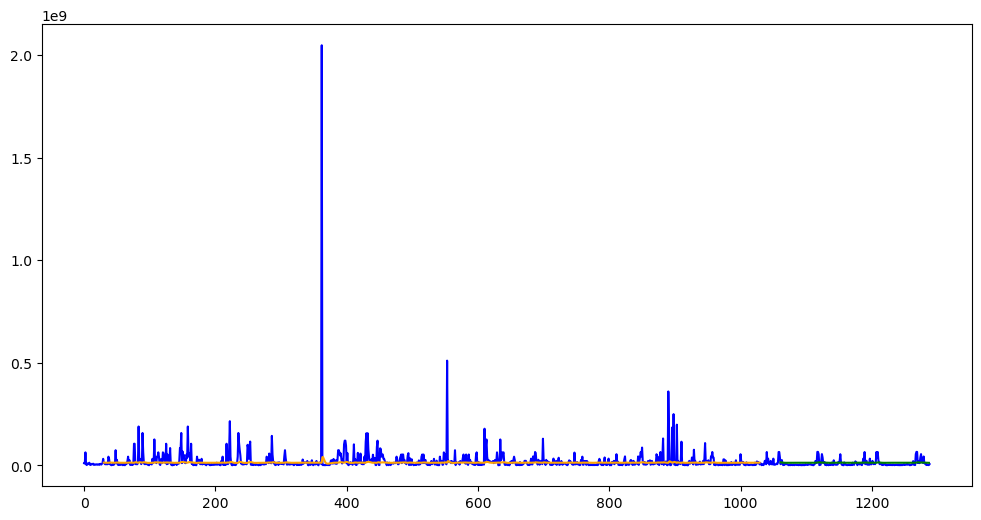

In [16]:
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(scaler.inverse_transform(scaled_data),
         label="Actual Sales", color='blue')

# Plot training predictions
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
plt.plot(trainPredictPlot, label="Train Prediction", color='orange')

# Plot test predictions
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back*2) +
                1:len(scaled_data)-1, :] = testPredict
plt.plot(testPredictPlot, label="Test Prediction", color='green')

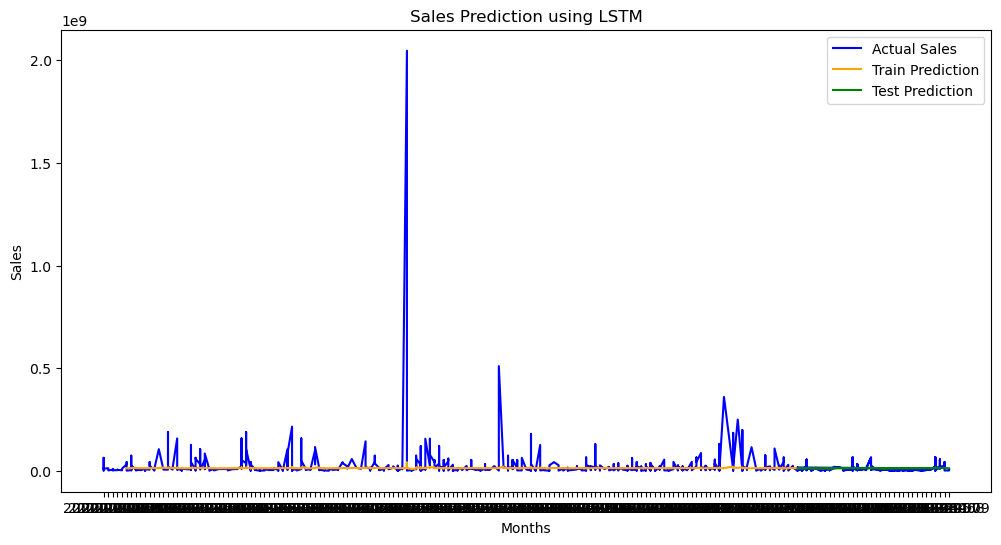

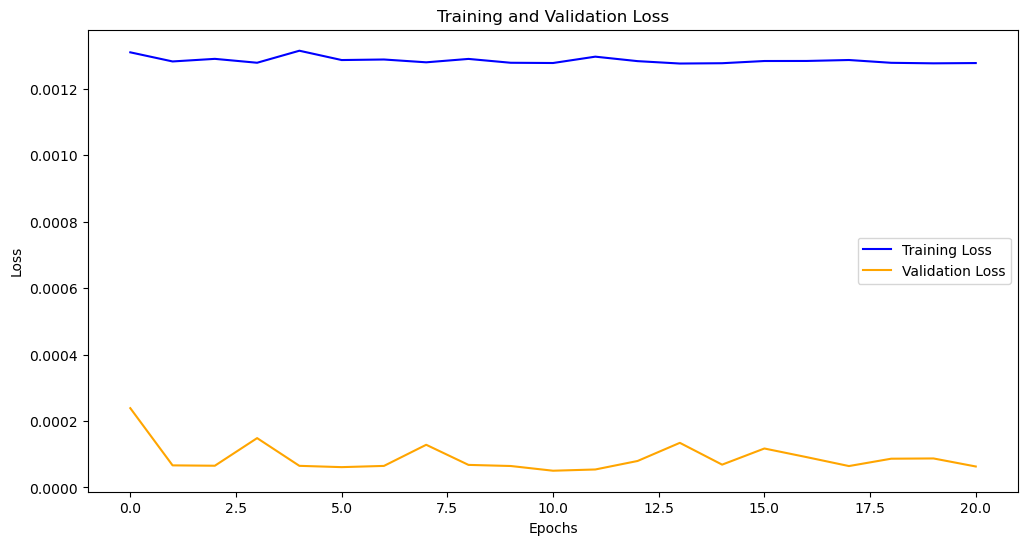

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['tanggal'], data['nominal'], label='Actual Sales', color='blue')
plt.plot(data['tanggal'].iloc[look_back:len(trainPredict) + look_back],
         trainPredict, label='Train Prediction', color='orange')
plt.plot(data['tanggal'].iloc[len(trainPredict) + (look_back*2) + 1:len(scaled_data)-1],
            testPredict, label='Test Prediction', color='green')
plt.plot(data['tanggal'].iloc[len(scaled_data)-1], next_prediction, marker='o', markersize=5, label='Next Prediction', color='red')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend()
plt.title('Sales Prediction using LSTM')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()